In [0]:
carol = """
We wish you a Merry Christmas
We wish you a Merry Christmas
We wish you a Merry Christmas and a happy New Year
Good tidings we bring to you and your kin
We wish you a Merry Christmas and a happy New Year
Oh, bring us some figgy pudding
Oh, bring us some figgy pudding
Oh, bring us some figgy pudding
And bring it right here
Good tidings we bring to you and your kin
We wish you a Merry Christmas and a happy New Year
We won't go until we get some
We won't go until we get some
We won't go until we get some
So bring it right here
Good tidings we bring to you and your kin
We wish you a Merry Christmas and a happy New Year
We all like our figgy pudding
We all like our figgy pudding
We all like our figgy pudding
With all its good cheers
Good tidings we bring to you and your kin
We wish you a Merry Christmas and a happy New Year
We wish you a Merry Christmas
We wish you a Merry Christmas
We wish you a Merry Christmas and a happy New Year
"""
carol = carol.replace("\n"," ")
carol = carol[1:]

In [2]:
chars = sorted(list(set(carol)))
char_to_int = dict((c, i) for i, c in enumerate(chars)) #중복제거 매핑
n_chars = len(carol)
n_vocab = len(chars)
print ("Total Characters: ", n_chars)
print ("Total Vocab: ", n_vocab)
seq_length = 100
dataX = []
dataY = []

for i in range(0, n_chars - seq_length, 1):
    seq_in = carol[i:i + seq_length]
    seq_out = carol[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print ("Total Patterns: ", n_patterns)

from keras.utils import np_utils
import numpy as np

x = np.reshape(dataX, (n_patterns, seq_length, 1))
x = x / float(n_vocab)
y = np_utils.to_categorical(dataY)

Total Characters:  942
Total Vocab:  33
Total Patterns:  842


Using TensorFlow backend.


In [3]:
!pip install keract

In [0]:
from tensorflow.keras.layers import Dense, Lambda, dot, Activation, concatenate

def attention_3d_block(hidden_states):
    # @author: felixhao28.
    # hidden_states.shape = (batch_size, time_steps, hidden_size)
    hidden_size = int(hidden_states.shape[2])
    # Inside dense layer
    #              hidden_states            dot               W            =>           score_first_part
    # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
    # W is the trainable weight matrix of attention Luong's multiplicative style score
    score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
    #            score_first_part           dot        last_hidden_state     => attention_weights
    # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
    h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
    score = dot([score_first_part, h_t], [2, 1], name='attention_score')
    attention_weights = Activation('softmax', name='attention_weight')(score)
    # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
    context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
    pre_activation = concatenate([context_vector, h_t], name='attention_output')
    attention_vector = Dense(128, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
    return attention_vector

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keract import get_activations
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

INPUT_DIM = 100
TIME_STEPS = 20

def get_model():
    #inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    inputs = Input(shape=(x.shape[1], x.shape[2]))
    rnn_out = LSTM(32, return_sequences=True)(inputs)
    attention_output = attention_3d_block(rnn_out)
    output = Dense(y.shape[1], activation='softmax', name='output')(attention_output)
    m = Model(inputs=[inputs], outputs=[output])
    print(m.summary())
    return m

In [15]:
n = 300000

m = get_model()
m.compile(optimizer='adam', loss='categorical_crossentropy')
    
history  = m.fit(x, y, epochs=1000, batch_size=64, validation_split=0)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 100, 32)      4352        input_2[0][0]                    
__________________________________________________________________________________________________
attention_score_vec (Dense)     (None, 100, 32)      1024        lstm_1[0][0]                     
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 32)           0           lstm_1[0][0]                     
____________________________________________________________________________________________

In [7]:
import sys
int_to_char = dict((i, c) for i, c in enumerate(chars))

start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print ("Seed:")
print ("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(100):
    out_x = np.reshape(pattern, (1, len(pattern), 1))
    out_x = out_x / float(n_vocab)
    prediction = m.predict(out_x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print ("\nDone.")

Seed:
" ng us some figgy pudding Oh, bring us some figgy pudding And bring it right here Good tidings we bri "
ng to you and your kin We wish you a Merry Christmas and a happy New Year We won't go until we get s
Done.


In [0]:
num_simulations = x.shape[2]
attention_vectors = np.zeros(shape=(num_simulations, seq_length))
for i in range(num_simulations):
    #testing_inputs_1, testing_outputs = get_data_recurrent(1, TIME_STEPS, INPUT_DIM)
    activations = get_activations(m, x, layer_name='attention_weight')
    #activations = K.function([m.layers[0].input], [m.layers[1].output])
    attention_vec = np.mean(activations['attention_weight'], axis=0).squeeze()
    assert np.abs(np.sum(attention_vec) - 1.0) < 1e-5
    attention_vectors[i] = attention_vec

In [9]:
attention_vectors

array([[0.13512263, 0.13961835, 0.0940786 , 0.04411322, 0.01979719,
        0.01439822, 0.01110976, 0.0114086 , 0.00866267, 0.00685656,
        0.00575454, 0.00532834, 0.00540187, 0.00795113, 0.00943266,
        0.01139118, 0.01282125, 0.01194157, 0.01225876, 0.00906023,
        0.00835505, 0.00935652, 0.00871045, 0.00836372, 0.00797222,
        0.00752989, 0.00723265, 0.00660852, 0.00554813, 0.00546073,
        0.005461  , 0.00594591, 0.00454838, 0.00341497, 0.00312499,
        0.00326432, 0.00311401, 0.00321527, 0.00314271, 0.0034774 ,
        0.00340396, 0.00255033, 0.00308987, 0.00263351, 0.00342418,
        0.00357503, 0.00527299, 0.00515606, 0.00446713, 0.00412357,
        0.0035901 , 0.00519988, 0.00447334, 0.00498578, 0.00355517,
        0.00349112, 0.00390798, 0.00372022, 0.00402825, 0.00442132,
        0.0043332 , 0.0049546 , 0.00504218, 0.00675202, 0.0056224 ,
        0.00525209, 0.00474318, 0.0043361 , 0.00454023, 0.00507622,
        0.00376964, 0.00347572, 0.0039722 , 0.00

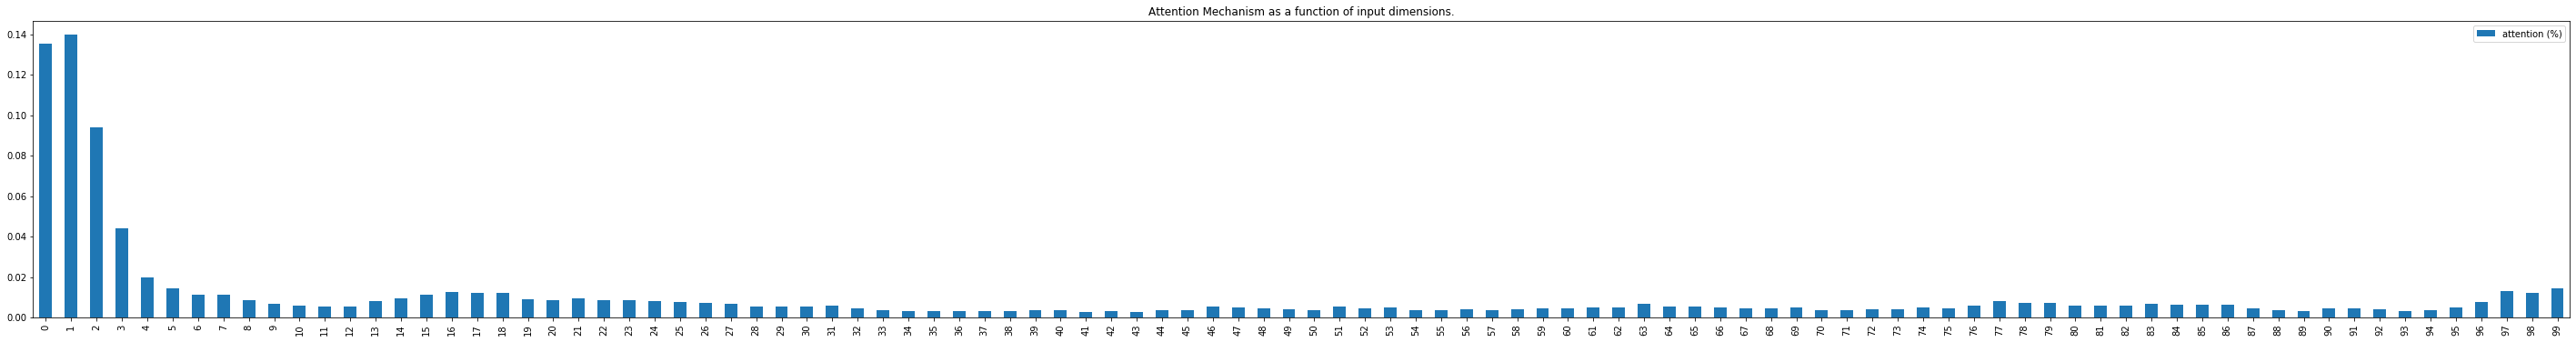

In [10]:
#attention_vector_final = list(np.mean(attention_vec, axis=0))
attention_df = pd.DataFrame(attention_vec, columns=['attention (%)'])
attention_df.plot(kind='bar', figsize=(50, 6), title='Attention Mechanism as a function of input dimensions.')
plt.show()

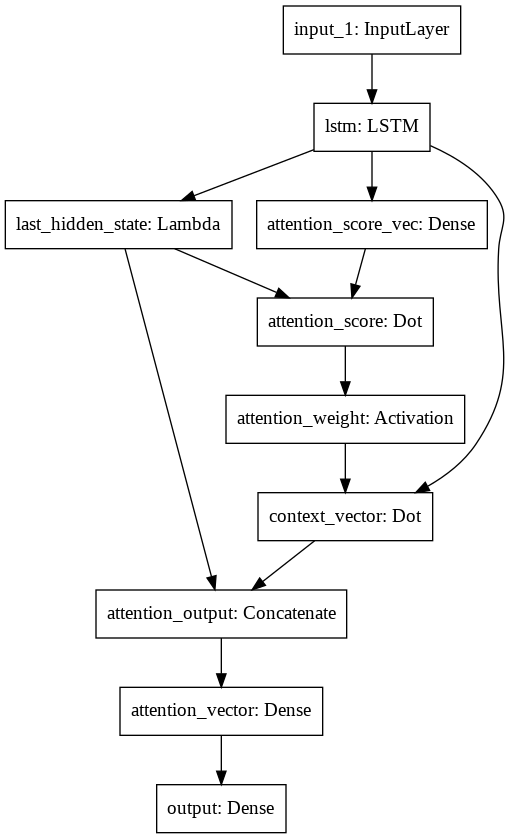

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(m, to_file='model.png')

In [21]:
history.history.keys()

dict_keys(['loss'])

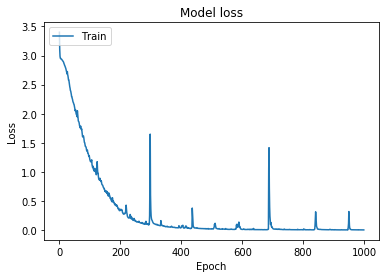

In [23]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()